In [1]:
import tensorflow as tf
%matplotlib inline

from sklearn import metrics
import random
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw ,ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

In [2]:
LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Great! You clicked on it correctly. Now let's get started.


In [3]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [5]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [7]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [8]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [9]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [10]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [11]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [12]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

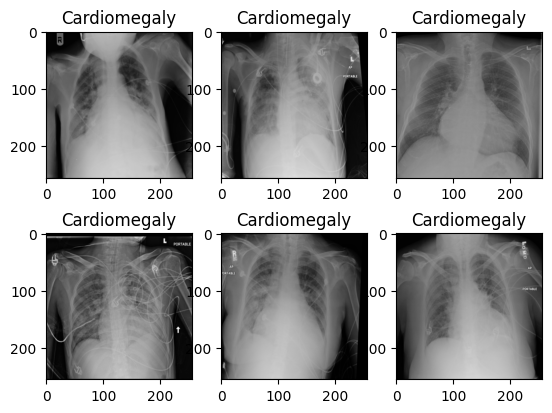

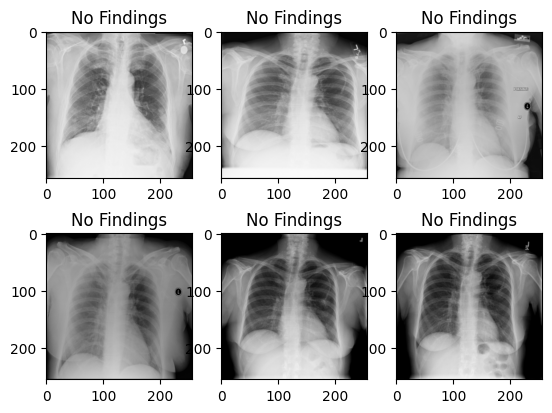

In [13]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [14]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

87910968/87910968 [==============================] - 1s 0us/step
Done compiling the model!


In [15]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [16]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


In [18]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
232/232 - 26s - loss: 8.8301 - acc: 0.5474 - val_loss: 1.3433 - val_acc: 0.7167 - 26s/epoch - 113ms/step
Epoch 2/20
232/232 - 11s - loss: 3.0054 - acc: 0.5733 - val_loss: 1.2831 - val_acc: 0.6000 - 11s/epoch - 50ms/step
Epoch 3/20
232/232 - 12s - loss: 1.0105 - acc: 0.6638 - val_loss: 0.8896 - val_acc: 0.5500 - 12s/epoch - 53ms/step
Epoch 4/20
232/232 - 12s - loss: 0.6679 - acc: 0.6853 - val_loss: 0.4606 - val_acc: 0.7833 - 12s/epoch - 50ms/step
Epoch 5/20
232/232 - 12s - loss: 0.5590 - acc: 0.7457 - val_loss: 0.5508 - val_acc: 0.7333 - 12s/epoch - 50ms/step
Epoch 6/20
232/232 - 12s - loss: 0.6560 - acc: 0.6595 - val_loss: 0.5740 - val_acc: 0.7167 - 12s/epoch - 52ms/step
Epoch 7/20
232/232 - 11s - loss: 0.5799 - acc: 0.7069 - val_loss: 0.4845 - val_acc: 0.7500 - 11s/epoch - 49ms/step
Epoch 8/20
232/232 - 12s - loss: 0.5047 - acc: 0.7629 - val_loss: 0.6556 - val_acc: 0.6833 - 12s/epoch - 51ms/step
Epoch 9/20
232/232 - 12s - loss: 0.5472 - acc: 0.7716 - val_loss: 0.5921 - val_

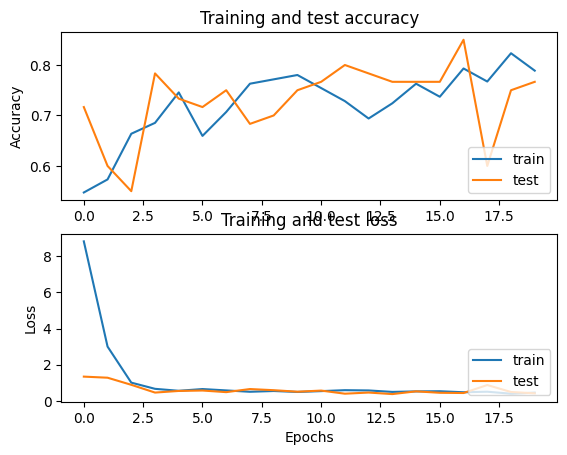

In [19]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [20]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [21]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 30ms/step
Done inference!


1/1 [==============================] - 0s 43ms/step


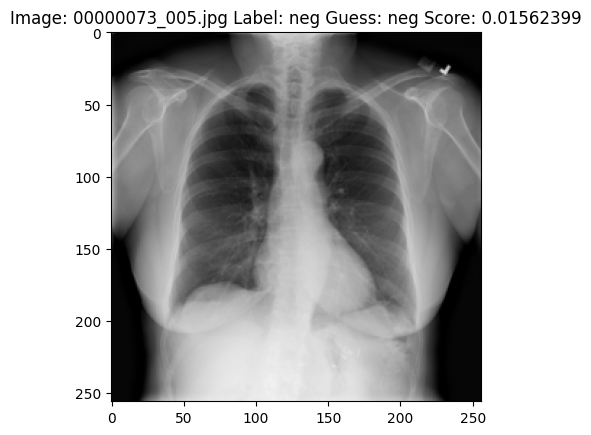

In [22]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [24]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.997059
5,00004344_013.jpg,pos,pos,0.948298
10,00012686_003.jpg,pos,pos,0.831382
15,00004822_051.jpg,pos,pos,0.757079
20,00018187_029.jpg,pos,pos,0.647612
25,00016414_000.jpg,pos,neg,0.485716
30,00000083_000.jpg,neg,neg,0.361503
35,00008399_007.jpg,pos,neg,0.266640
40,00000081_000.jpg,neg,neg,0.092436
45,00000087_001.jpg,neg,neg,0.046564


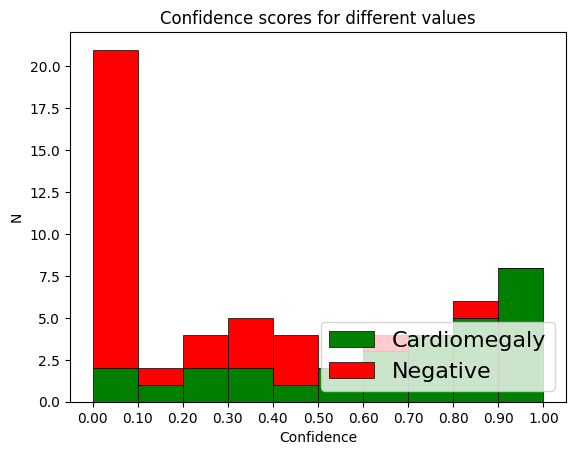

In [25]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [26]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

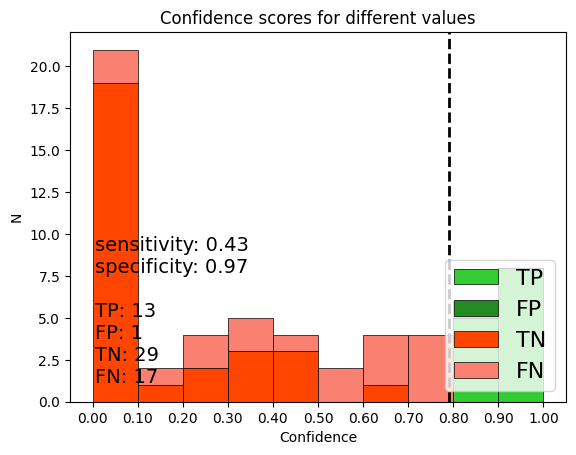

In [27]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

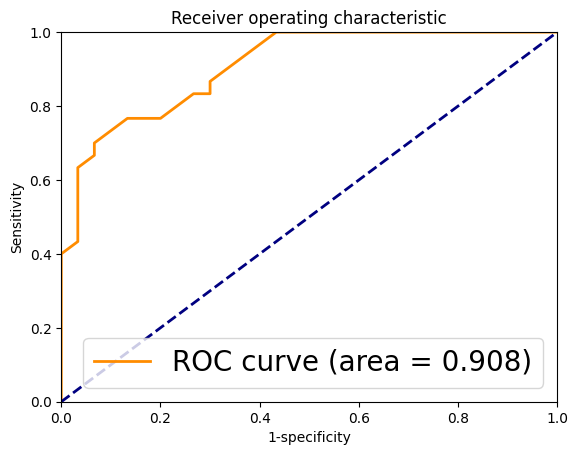

In [29]:
from sklearn import metrics
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()